# Processing GC-FID data with the apolar phase
This notebook shows how to read, annotate and quantify peaks in the apolar phase of GC-FID data together with a calibration run. An attempt is made to automate the peak annotations by matching the pattern of the standard to the measurement. Apart from the annotation, this workflow should be applicable for any type of intensity vs retention time / mass measurement.

## Imports
We start by making the necessary imports. If you see errors, it probably means that you are missing some packages. `matplotlib` and `numpy` are standard packages used in most applications. `GC` is the package written by me and extends the `chem_spectra` package also written by me which is currently available on `github` through <https://github.com/yaza11/chem_spectra> or PyPI (`pip install chem-spectra`). Run the cell below to make sure you have the newest version

In [91]:
# !pip install chem-spectra
# !pip install git+https://github.com/yaza11/chem_spectra.git

and the GC package

In [52]:
# not needed if you run this from the project folder itself
...

In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# use notebook for interactive zooming and panning

In [54]:
from GC.from_cdf import GcCdfReader

## File setup
Next we need to define which measurements we want to process. We need to specify the full path for the calibration and actual measurement. Make sure to put an r in front of the string if you use backslashes in the path (default for windows). Usually backslashes are used when define special characters such as \t for tab and \n for a line break which is not what we want.

In [55]:
file = r"\\hlabstorage.dmz.marum.de\scratch\Yannick\gc-fid\fileformatsapolarfractions\1807rka.cdf"
file_calib = r"\\hlabstorage.dmz.marum.de\scratch\Yannick\gc-fid\fileformatsapolarfractions\1807alk1.cdf"

## Reading the data
We use `scipy`'s netcdf_file reader to open the file and extract the necessary information. It is stored in a `GcCdfReader` instance.

In [56]:
rdr = GcCdfReader(file, is_standard_run=False)
rdr_calib = GcCdfReader(file_calib, is_standard_run=True)

Let's check what information we have

In [57]:
{k: v for k, v in rdr.__dict__.items() if not k.startswith("_")}

{'filename': '\\\\hlabstorage.dmz.marum.de\\scratch\\Yannick\\gc-fid\\fileformatsapolarfractions\\1807rka.cdf',
 'fp': <_io.BufferedReader name='\\\\hlabstorage.dmz.marum.de\\scratch\\Yannick\\gc-fid\\fileformatsapolarfractions\\1807rka.cdf'>,
 'use_mmap': False,
 'mode': 'r',
 'version_byte': np.int8(1),
 'maskandscale': False,
 'dimensions': {'_2_byte_string': 2,
  '_8_byte_string': 8,
  '_16_byte_string': 16,
  '_64_byte_string': 64,
  '_128_byte_string': 128,
  '_255_byte_string': 255,
  '_4_byte_string': 4,
  '_32_byte_string': 32,
  'point_number': 41099,
  'peak_number': 61},
 'variables': {'actual_sampling_interval': <scipy.io._netcdf.netcdf_variable at 0x25bdddc1ee0>,
  'actual_delay_time': <scipy.io._netcdf.netcdf_variable at 0x25bddccaea0>,
  'actual_run_time_length': <scipy.io._netcdf.netcdf_variable at 0x25bddd12720>,
  'detector_maximum_value': <scipy.io._netcdf.netcdf_variable at 0x25bddd12600>,
  'detector_minimum_value': <scipy.io._netcdf.netcdf_variable at 0x25bdddb63

## Process the spectra
We can use this information to instantiate `Spectrum` objects that hold the intensity vs retention time data. They also define the functions we need for further processing.

In [58]:
spec = rdr.get_spectrum(use_available_baseline=False, use_available_peaks=False)
spec_calib = rdr_calib.get_spectrum(use_available_baseline=False, use_available_peaks=False)

Notice that we specified `use_available_baseline=False` and `use_available_peaks=False`. Oftentimes the cdf file already contains information about this but it is not useful for this pipeline.

### Resampling
It is important to make sure that the intensities were taken at regular time intervals. For GC-FID data this is usually already the case but we are on the safe side if we enforce it here.

In [59]:
dx = np.median(np.diff(spec.x))
spec.resample(dx=dx)
spec_calib.resample(x_new=spec.x)

In [60]:
dx

np.float64(0.0016666670562699437)

Let's have a look what those spectra look like. Calling `plot` on a `Spectrum` instance will create or modify a `plt.Axes` object and add a simple y vs x line. As you will later see, there are also plotting functions

<Axes: >

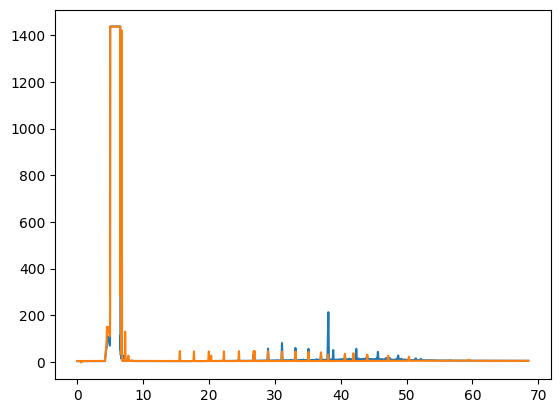

In [61]:
ax = spec.plot()
spec_calib.plot(ax=ax)

### Cropping
We can see the calibrant in orange and the measurement in blue. For further processing we need to cut off the injection peak.

In [62]:
spec.set_window([15, 65])
spec_calib.set_window([15, 65])

(0.0, 75.0)

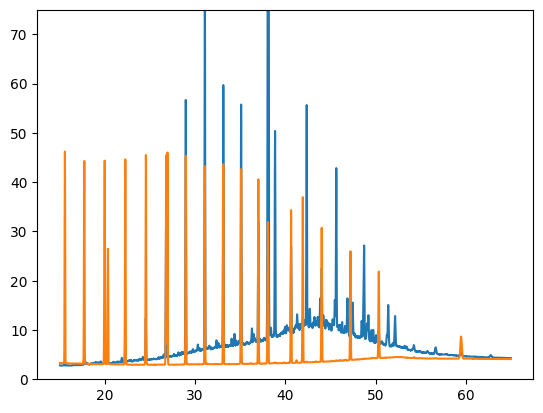

In [63]:
ax = spec.plot()
spec_calib.plot(ax=ax)
ax.set_ylim([0, 75])

### Baseline
In the plot above it is quite apparent that we have some undesired background signal. We need to find and subtract the baseline. Different methods for doing this exist but we use the default here which is running a minimum followed by a median filter. Defining the right window length is crucial but the automatic window determination (based on the peak widths) usually works quite well. If this, for some reason, is not the case, you can provide the `window_size` parameter to `find_baseline`.

<Axes: >

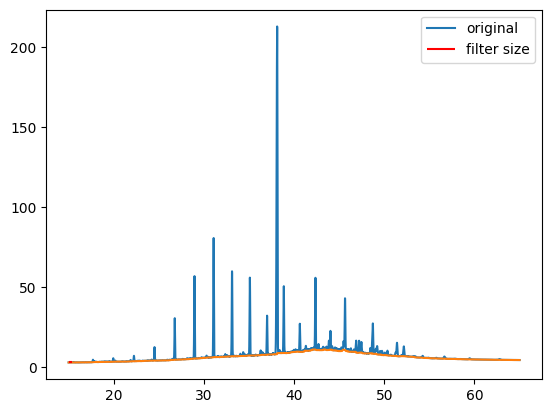

In [64]:
spec.find_baseline()
spec.baseline.plot(x=spec.x, y=spec.y)

The red line on the left shows you the window size of the filter. Make sure it is wider than the peaks but not too wide.

<Axes: >

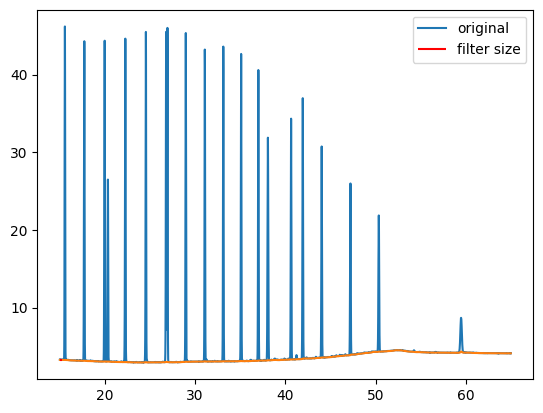

In [65]:
spec_calib.find_baseline()
spec_calib.baseline.plot(x=spec_calib.x, y=spec_calib.y)

In [66]:
spec.subtract_baseline()
spec_calib.subtract_baseline()

### Peak positions
Next, we need to define where we have peaks to distinguish them from noise.

At this step we can already try to limit ourselves to peaks that we will use for quantification later. Peaks, that are very close to each other can be an issue when we assign annotations. By requiring a minimum distance between peaks, we can circumvent this issue. Since we are wrapping `scipy`s `find_peaks` function, we need to provide the distance in sample points. If we want a minimum distance of 1 minute, we would provide `distance=1 / dx`.

we can specify the minimum distance as ~ 1 minute

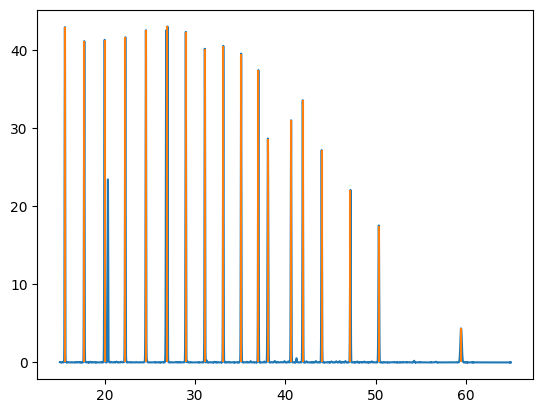

In [67]:
spec_calib.find_peak_positions(rel_to='max', rel_prominence=.03, distance=1 / dx)
ax = spec_calib.peak_finder.plot()

### Peak annotations
By matching the peak pattern to the expected one, we can assign peak labels. If you set `plts=True` you will see the expected pattern in orange and the measured one in blue dashed. If you don't see the blue dashed line it is likely below the orange line.

initial score: -0.9741192537944748
final score: -0.9746077757488795


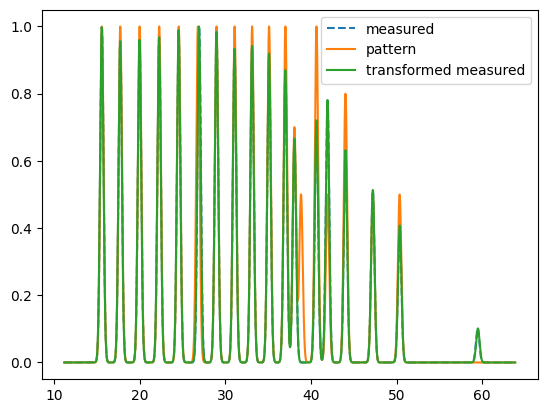

In [68]:
spec_calib.annotate_peaks(plts=True)

<Axes: >

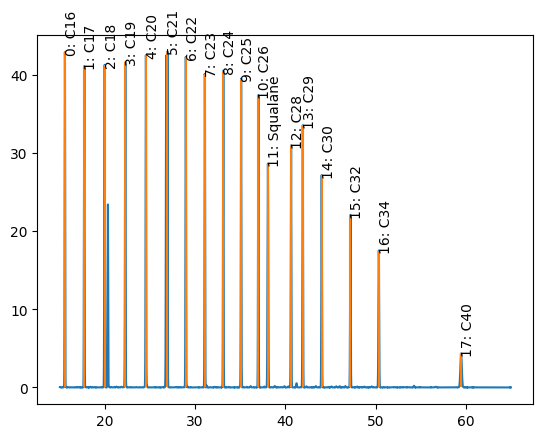

In [69]:
ax = spec_calib.plot()
spec_calib.plot_peaks(ax=ax)

If we find any wrongly assigned peaks, we could change it here by calling the `annotate_peaks_manually` function which will overwrite the peaks at specified indices. Notice that you need to specify `None` if you want to remove labels.

In [70]:
# spec_calib.annotatate_peaks_manually({2: 'C18', 3: None, 7: None, 6: 'C21'})
# spec_calib.plot_peaks()

### match peaks in standard to measurement
We can use the same idea for the measurement. This time we want to match the measurement to the calibration.

But first we need to find the peak positions again. Here the peaks are less prominent and without the distance argument we would pick up a lot of noisy peaks.

<Axes: >

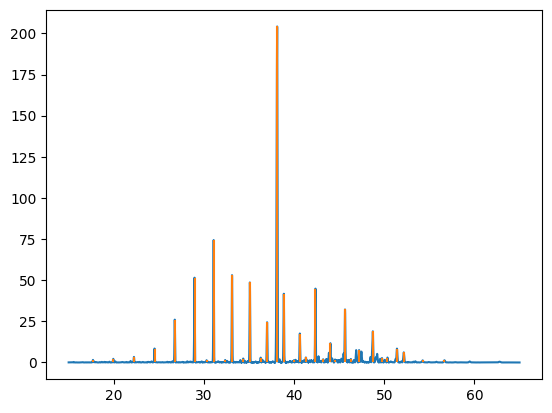

In [71]:
spec.find_peak_positions(rel_to='max', rel_prominence=.005, distance=.5 / np.diff(spec.x)[0])
ax = spec.plot()
spec.plot_peaks(ax=ax)
# ax.set_xlim([20, 50])

Also, the match will be worse

initial score: -0.39758673086816715
final score: -0.39842586432803134


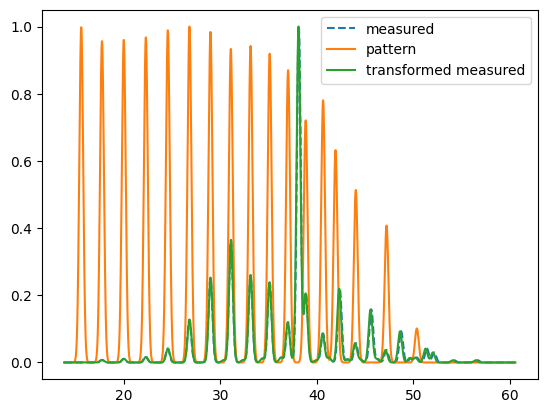

In [72]:
spec.add_std_annotations(spec_calib, plts=True)

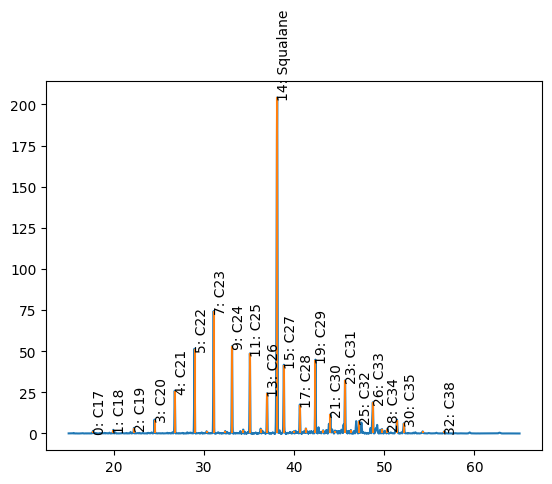

In [73]:
ax = spec.plot()
ax = spec.plot_peaks(ax=ax)

Again, we could re-assign peaks, if necessary

In [74]:
# spec.annotatate_peaks_manually({44: None, 43: 'C33'})

### filter out peaks without annotations

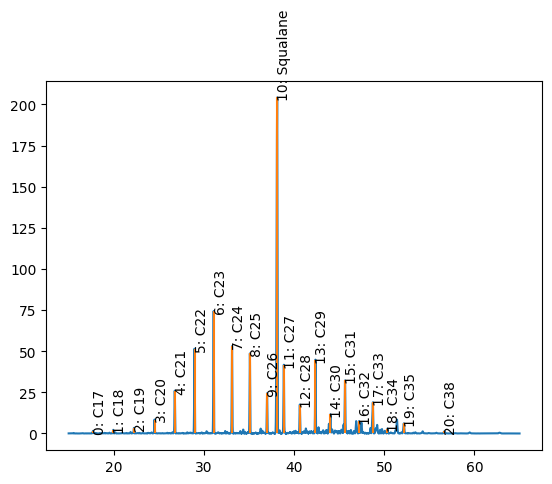

In [75]:
# %matplotlib notebook
spec.peak_list.peaks = [p for p in spec.peak_list.peaks if p.annotation is not None]

ax = spec.plot()
ax = spec.plot_peaks(ax=ax)

### Integrate
Now that we know which peaks we are interested in, we can quantify them by finding integration bounds.

<Axes: >

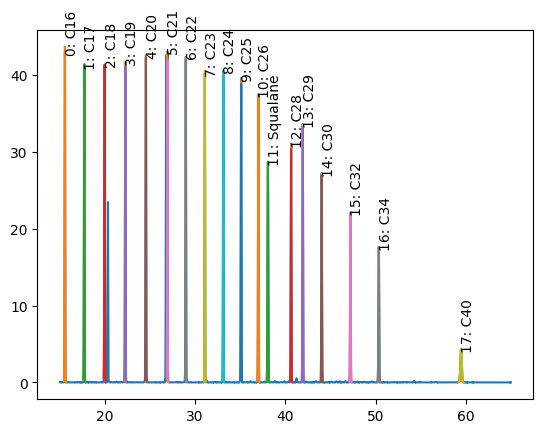

In [76]:
spec_calib.find_peak_parameters()
ax = spec_calib.plot()
spec_calib.plot_peaks(ax=ax)

you can zoom in on specific peaks to see how well the fit is

<Axes: >

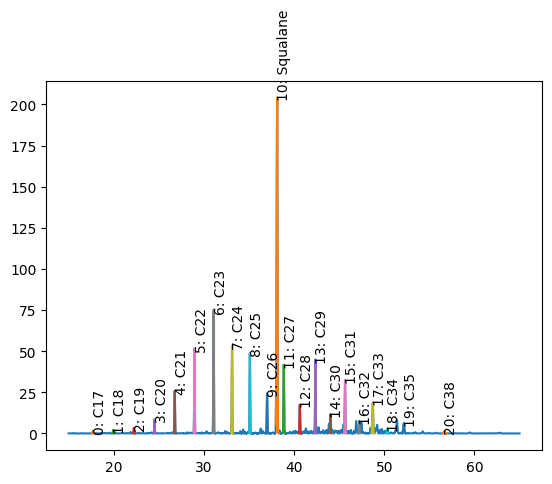

In [77]:
spec.find_peak_parameters()
ax = spec.plot()
spec.plot_peaks(ax=ax)

In [78]:
spec.set_peak_abundances(use_fitted=False, integrate=True)
spec_calib.set_peak_abundances(use_fitted=False, integrate=True)

If you zoom in on peaks you will see the integrated area. Notice that by default some area close to the boundaries is excluded since it becomes increasingly more difficult to distinguish signal from noise or other peaks. As long as we are doing this consistently for all peaks, this is not an issue.

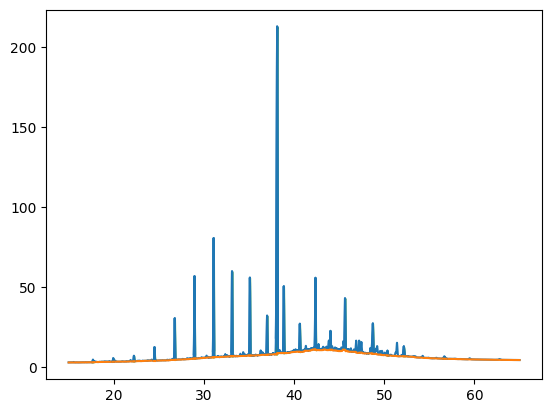

In [79]:
plt.plot(spec.x, spec.y + spec.baseline.y_baseline)
plt.plot(spec.x, spec.baseline.y_baseline)
spec.plot_integrated_peak(ax=plt.gca())
plt.show()

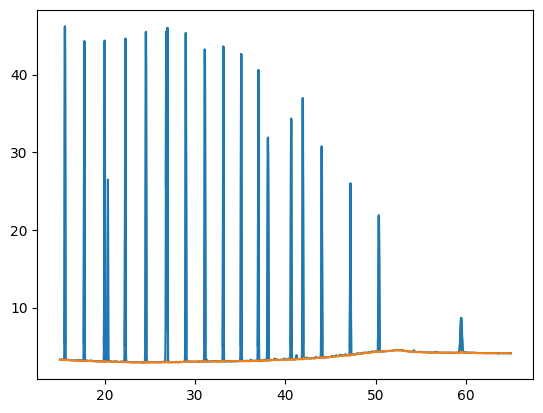

In [80]:
plt.plot(spec_calib.x, spec_calib.y + spec_calib.baseline.y_baseline)
plt.plot(spec_calib.x, spec_calib.baseline.y_baseline)
spec_calib.plot_integrated_peak(ax=plt.gca())
plt.show()

### Dataframe
With a bit of renaming we end up with two neet tables that show us the area of each peak

In [81]:
areas = spec.to_dataframe().set_index('annotation').rename(columns={'x': 'RT', 'q': 'area'})
areas_calib = spec_calib.to_dataframe().set_index('annotation').rename(columns={'x': 'RT', 'q': 'area'})

In [82]:
areas.head()

,RT,area
annotation,,
C17,17.696671,0.118705
C18,19.950005,0.159510
C19,22.238339,0.237207
C20,24.521672,0.578665
C21,26.766673,1.796120


## Normalization with standard
To factor out analytical variability we divide areas by respective ones from the standard

In [85]:
# change these values as needed
sample_volume = 100  # ng / muL
sample_volume_calib = 10  # ng / muL

In [86]:
recovery = (areas.loc['Squalane', 'area'] / sample_volume) / (areas_calib.loc['Squalane', 'area'] / sample_volume_calib)
print(f'{recovery=:.1%}')  # --> 79.2, matches excel

recovery=79.2%


normalize measured quantities with standard

In [87]:
# for missing compounds we interpolate between peaks
def from_interpolated(known_rts, known_areas):
    """Define function that converts the retention time of a peak to an area"""
    o  = np.argsort(known_rts)
    def inner(unknown_rt):
        interpolated_areas = np.interp(unknown_rt, known_rts.iloc[o], known_areas.iloc[o])
        return interpolated_areas
    return inner

# peaks used for interpolation
peaks_in_both = sorted(set(areas.index) & set(areas_calib.index))
# thus assuming linear dependence between retention time and peak area (for compounds in the calibration run)
inter_func = from_interpolated(known_rts=areas_calib.loc[peaks_in_both, 'RT'], known_areas=areas_calib.loc[peaks_in_both, 'area'])

# use matched peaks for those available and interpolation function for others
areas.loc[:, 'normalized_area'] = areas.apply(
    lambda row:
    row['area'] * sample_volume / (areas_calib.loc[lbl, 'area'] / sample_volume_calib)
    if (lbl := row.name) in areas_calib.index
    else row['area'] * sample_volume / (inter_func(row['RT']) / sample_volume_calib),
    axis=1
)

### Visualize the peak area interpolation function

Text(0, 0.5, 'area')

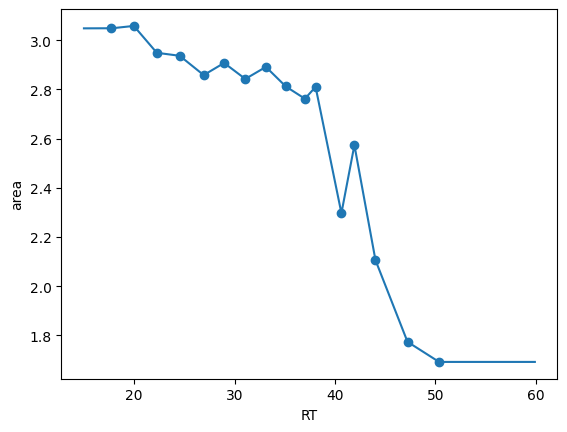

In [88]:
fig, axs = plt.subplots()
rts_plot = np.arange(15, 60, .1)
axs.scatter(areas_calib.loc[peaks_in_both, 'RT'], areas_calib.loc[peaks_in_both, 'area'])
axs.plot(rts_plot, inter_func(rts_plot))
axs.set_xlabel('RT')
axs.set_ylabel('area')

In [89]:
areas

,RT,area,normalized_area
annotation,,,
C17,17.696671,0.118705,38.943050
C18,19.950005,0.159510,52.160861
C19,22.238339,0.237207,80.441127
C20,24.521672,0.578665,197.053271
C21,26.766673,1.796120,628.426417
C22,28.956673,3.631975,1249.177127
C23,31.080007,5.423139,1907.920164
C24,33.116674,3.872272,1339.253179
C25,35.095008,3.535041,1257.162357


# Export
We have multiple options to export this data. Common formats are excel and csv.

In [90]:
import os

path_folder = r'\\hlabstorage.dmz.marum.de\scratch\Yannick\gc-fid\fileformatsapolarfractions'

areas.to_csv(os.path.join(path_folder, 'areas.csv'))
areas.to_excel(os.path.join(path_folder, "areas.xlsx"))

areas.to_csv(os.path.join(path_folder, "calibration_areas.csv"))
areas.to_excel(os.path.join(path_folder, "calibration_areas.xlsx"))